In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import random
from lightfm import LightFM
import json

SEED = 42
pysqldf = lambda q: sqldf(q, globals())

rec_path = r'/Users/erik/Downloads/archive(1)/recommendations.csv'
games_path = r'/Users/erik/Downloads/archive(1)/games.csv'
users_path = r'/Users/erik/Downloads/archive(1)/users.csv'
games_metadata_path = r'/Users/erik/Downloads/archive(1)/games_metadata.json'


/Users/erik/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
def generate_int_id(df, id_col_name):
    new_df=df.assign(
        int_id_col_name=np.arange(len(df))
        ).reset_index(drop=True)
    return new_df.rename(columns={'int_id_col_name': id_col_name})

In [3]:
recommendations = pd.read_csv(rec_path)
games = pd.read_csv(games_path)
users = pd.read_csv(users_path)
games_metadata = pd.read_json(games_metadata_path, lines=True)

In [9]:
users.loc[users['reviews'] >= 20]

,user_id,products,reviews
33,1965432,702,32
339,4834290,433,36
541,6116691,262,24
555,20561,494,33
596,136427,172,22
...,...,...,...
6161915,93254,362,20
6163785,680714,304,21
6164214,807989,458,43
6164311,839326,185,24


In [12]:
df_users = generate_int_id(users.loc[users['reviews'] >= 20], 'user_id_num')
df_users.head(10)

,user_id,products,reviews,user_id_num
0,1965432,702,32,0
1,4834290,433,36,1
2,6116691,262,24,2
3,20561,494,33,3
4,136427,172,22,4
5,2155993,1882,38,5
6,2184855,222,20,6
7,2297109,1246,22,7
8,2317937,2646,24,8
9,2460068,504,45,9


In [14]:
df_games = generate_int_id(games, 'app_id_num')
df_games = pd.merge(df_games, games_metadata, how='left', on='app_id')
df_games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,app_id_num,description,tags
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True,0,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,1,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,2,,[Action]
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,3,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,4,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,2023-03-01,True,False,False,Very Positive,96,65,12.49,12.49,0.0,True,48313,Gone Rogue is a tactical stealth game with RPG...,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,Wildfrost,2023-04-12,True,False,False,Mixed,64,1819,19.99,19.99,0.0,True,48314,"Take on the elements in Wildfrost, a tactical ...","[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,BLACK ACE,2022-02-03,True,False,False,Mixed,44,76,0.00,0.00,0.0,True,48315,Competitive multiplayer match with vehicles an...,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,BandRoll,2023-04-14,True,False,False,Positive,96,26,1.59,1.99,20.0,True,48316,Feel the Neon in Your Bones! How would you lik...,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [31]:
games_feature_list = df_games.explode('tags', ignore_index=True)['tags']
games_feature_list

0                  Zombies
1             World War II
2                      FPS
3              Multiplayer
4                   Action
                ...       
566945        Singleplayer
566946       Immersive Sim
566947          Story Rich
566948    Post-apocalyptic
566949       Transhumanism
Name: tags, Length: 566950, dtype: object

In [36]:
df_games['app_features'] = list(zip(df_games['app_id_num'], df_games['tags']))
df_games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,app_id_num,description,tags,app_features
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True,0,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti...","(0, [Zombies, World War II, FPS, Multiplayer, ..."
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,1,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre...","(1, [Action, Adventure, Parkour, Third Person,..."
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,2,,[Action],"(2, [Action])"
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,3,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...","(3, [Co-op, Stealth, Indie, Heist, Local Co-Op..."
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,4,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P...","(4, [Zombies, Adventure, Survival, Action, Thi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,2023-03-01,True,False,False,Very Positive,96,65,12.49,12.49,0.0,True,48313,Gone Rogue is a tactical stealth game with RPG...,"[Stealth, Action, Real Time Tactics, Isometric...","(48313, [Stealth, Action, Real Time Tactics, I..."
48314,1811990,Wildfrost,2023-04-12,True,False,False,Mixed,64,1819,19.99,19.99,0.0,True,48314,"Take on the elements in Wildfrost, a tactical ...","[Card Battler, Difficult, Roguelike Deckbuilde...","(48314, [Card Battler, Difficult, Roguelike De..."
48315,1868120,BLACK ACE,2022-02-03,True,False,False,Mixed,44,76,0.00,0.00,0.0,True,48315,Competitive multiplayer match with vehicles an...,"[FPS, Third-Person Shooter, Multiplayer, Shoot...","(48315, [FPS, Third-Person Shooter, Multiplaye..."
48316,2206390,BandRoll,2023-04-14,True,False,False,Positive,96,26,1.59,1.99,20.0,True,48316,Feel the Neon in Your Bones! How would you lik...,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher...","(48316, [3D Platformer, Rhythm, Parkour, 3D, A..."


In [316]:
user_app_ratings = pd.merge(df_users, recommendations, how="inner", on=["user_id"])

In [317]:
user_app_ratings['app_id'].nunique()

1799

In [141]:
user_app_ratings

,user_id,products,reviews,user_id_num,app_id,helpful,funny,date,is_recommended,hours,review_id
0,1965432,702,32,0,264710,0,2,2018-05-30,True,33.9,2063767
1,1965432,702,32,0,239030,0,0,2013-12-12,True,10.3,4517660
2,1965432,702,32,0,250900,0,0,2017-02-17,True,61.6,5762464
3,1965432,702,32,0,607080,2,0,2021-12-25,True,19.0,6152399
4,1965432,702,32,0,335300,2,0,2017-01-01,True,164.0,6410467
...,...,...,...,...,...,...,...,...,...,...,...
429428,922219,72,25,14955,1361000,28,19,2022-06-26,True,1.1,9366376
429429,922219,72,25,14955,289650,0,0,2022-06-24,True,16.1,9639562
429430,922219,72,25,14955,424840,0,0,2021-12-28,False,2.7,9697813
429431,922219,72,25,14955,633230,0,0,2021-12-28,True,10.0,11229597


In [318]:
user_app_ratings = user_app_ratings.drop(columns=['reviews', 'products', 'helpful', 'funny', 'date', 'hours', 'review_id'])
user_app_ratings

,user_id,user_id_num,app_id,is_recommended
0,1965432,0,264710,True
1,1965432,0,239030,True
2,1965432,0,250900,True
3,1965432,0,607080,True
4,1965432,0,335300,True
...,...,...,...,...
429428,922219,14955,1361000,True
429429,922219,14955,289650,True
429430,922219,14955,424840,False
429431,922219,14955,633230,True


In [319]:
user_app_ratings_2 = user_app_ratings.copy()
user_app_ratings_2['is_recommended'] = user_app_ratings_2['is_recommended'].map({False: -1, True: 1})
user_app_ratings_2 = user_app_ratings_2.sort_values('user_id')
user_app_ratings_2

,user_id,user_id_num,app_id,is_recommended
83525,464,2900,323320,1
83515,464,2900,254700,1
83516,464,2900,35450,1
83517,464,2900,250400,1
83518,464,2900,46510,1
...,...,...,...,...
88609,6167506,3078,250900,1
88610,6167506,3078,823500,1
88611,6167506,3078,881100,1
88604,6167506,3078,1229490,1


In [ ]:
unique_users = user_app_ratings_2['user_id'].to_list()
list(dict.fromkeys(unique_users))

user_app_ratings_2.loc[user_app_ratings_2['user_id']== 464]

In [ ]:
n = 0.25
temp = user_app_ratings_2.drop(user_app_ratings_2.query('user_id ==' + str(unique_users[0])).sample(frac=n, random_state=1).index)
#user_app_ratings_2.loc[user_app_ratings_2['user_id']== 464]
temp

In [320]:
def generate_train_set(df, n):
    unique_users = user_app_ratings_2['user_id'].to_list()
    lst = list(dict.fromkeys(unique_users))
    train_set = df.copy()
    for i in lst:
        train_set = train_set.drop(train_set.query('user_id ==' + str(i)).sample(frac=n, random_state=1).index)

    return train_set

In [321]:
new_train_set = generate_train_set(user_app_ratings_2, 0.25)
new_train_set

,user_id,user_id_num,app_id,is_recommended
83525,464,2900,323320,1
83515,464,2900,254700,1
83516,464,2900,35450,1
83518,464,2900,46510,1
83519,464,2900,232430,1
...,...,...,...,...
88608,6167506,3078,244850,1
88609,6167506,3078,250900,1
88611,6167506,3078,881100,1
88604,6167506,3078,1229490,1


In [311]:
len(new_train_set.loc[new_train_set['user_id']== 1965432])

24

In [312]:
len(user_app_ratings_2.loc[user_app_ratings_2['user_id']== 1965432])

32

In [322]:
new_train_set['app_id'].nunique()

1780

In [323]:
new_test_set = user_app_ratings_2.copy()

In [324]:
new_test_set['app_id'].nunique()

1799

In [352]:
user_app_ratings_2

,user_id,user_id_num,app_id,is_recommended
83525,464,2900,323320,1
83515,464,2900,254700,1
83516,464,2900,35450,1
83517,464,2900,250400,1
83518,464,2900,46510,1
...,...,...,...,...
88609,6167506,3078,250900,1
88610,6167506,3078,823500,1
88611,6167506,3078,881100,1
88604,6167506,3078,1229490,1


In [ ]:
test_data_set = user_app_ratings_2.copy()

In [151]:
user_app_ratings['is_recommended'] = user_app_ratings['is_recommended'].map({False: -1, True: 2})
user_app_ratings

,user_id,user_id_num,app_id,is_recommended
0,1965432,0,264710,2
1,1965432,0,239030,2
2,1965432,0,250900,2
3,1965432,0,607080,2
4,1965432,0,335300,2
...,...,...,...,...
429428,922219,14955,1361000,2
429429,922219,14955,289650,2
429430,922219,14955,424840,-1
429431,922219,14955,633230,2


In [325]:
#Create Dataset
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((user_app_ratings['user_id']), (user_app_ratings['app_id']))

In [326]:
dataset.interactions_shape()

(14956, 1799)

In [ ]:
mapping = dataset.mapping()

In [410]:
mapping[0]

{1965432: 0,
 4834290: 1,
 6116691: 2,
 20561: 3,
 136427: 4,
 2155993: 5,
 2184855: 6,
 2297109: 7,
 2317937: 8,
 2460068: 9,
 2788401: 10,
 3003685: 11,
 3255621: 12,
 3333500: 13,
 3849267: 14,
 3920403: 15,
 3921960: 16,
 3949973: 17,
 4345650: 18,
 4585358: 19,
 4622182: 20,
 4641608: 21,
 4714201: 22,
 4744710: 23,
 4747169: 24,
 4784452: 25,
 4796028: 26,
 4798902: 27,
 4846622: 28,
 4886174: 29,
 4945666: 30,
 4958924: 31,
 4990239: 32,
 4999305: 33,
 5038416: 34,
 5073655: 35,
 5164976: 36,
 5220712: 37,
 5221090: 38,
 5221269: 39,
 5289372: 40,
 5297648: 41,
 5574370: 42,
 5966482: 43,
 6013833: 44,
 6159675: 45,
 110466: 46,
 433025: 47,
 699249: 48,
 704990: 49,
 1080655: 50,
 1080868: 51,
 1281016: 52,
 1323785: 53,
 1953383: 54,
 2186963: 55,
 2299355: 56,
 2376531: 57,
 2404164: 58,
 2472412: 59,
 2600393: 60,
 2654419: 61,
 2795303: 62,
 2824820: 63,
 2860212: 64,
 2967704: 65,
 3015115: 66,
 3031627: 67,
 3168944: 68,
 3225157: 69,
 3453838: 70,
 4284407: 71,
 5383047:

In [213]:
game_tags = pd.merge(user_app_ratings, games_metadata, how='left', on='app_id')
game_tags

,user_id,user_id_num,app_id,is_recommended,description,tags
0,1965432,0,264710,2,Descend into the depths of an alien underwater...,"[Open World Survival Craft, Survival, Open Wor..."
1,1965432,0,239030,2,Congratulations. The October labor lottery is ...,"[Indie, Political, Simulation, Singleplayer, P..."
2,1965432,0,250900,2,The Binding of Isaac: Rebirth is a randomly ge...,"[Action Roguelike, Roguelike, Indie, Replay Va..."
3,1965432,0,607080,2,Combining quirky missions and mysterious consp...,"[Story Rich, 3D Platformer, Psychological, Com..."
4,1965432,0,335300,2,DARK SOULS™ II: Scholar of the First Sin bring...,"[Souls-like, Dark Fantasy, RPG, Difficult, Act..."
...,...,...,...,...,...,...
429428,922219,14955,1361000,2,In Silence is a multiplayer horror game. One p...,"[Horror, Multiplayer, Online Co-Op, Survival H..."
429429,922219,14955,289650,2,Assassin’s Creed® Unity tells the story of Arn...,"[Open World, Parkour, Assassin, Stealth, Histo..."
429430,922219,14955,424840,-1,"Immerse yourself in Little Nightmares, a dark ...","[Horror, Atmospheric, Adventure, Singleplayer,..."
429431,922219,14955,633230,2,Battle as a team of 4 to compete against other...,"[Anime, Action, Character Customization, Multi..."


In [219]:
game_tags_exploded = game_tags.explode('tags', ignore_index=True)
#len(set(game_tags_exploded))

In [223]:
dataset.fit_partial(items=game_tags_exploded['app_id'], item_features=game_tags_exploded['tags'])

In [174]:
games_exploded = df_games.explode('tags', ignore_index=True)
dataset.fit_partial(items=games_exploded['app_id'], item_features=games_exploded['tags'])

In [201]:
ls = list(zip(user_app_ratings.user_id, user_app_ratings.app_id, user_app_ratings.is_recommended))

In [327]:
# List from new train test
ls_new_train_set = list(zip(new_train_set.user_id, new_train_set.app_id, new_train_set.is_recommended))

In [330]:
# build with new trainset
(interactions_new_train, weights) = dataset.build_interactions(ls_new_train_set)
print(repr(interactions_new_train))

<14956x1799 sparse matrix of type '<class 'numpy.int32'>'
	with 321823 stored elements in COOrdinate format>


In [329]:
(interactions, weights) = dataset.build_interactions(ls)
print(repr(interactions))

<14956x1799 sparse matrix of type '<class 'numpy.int32'>'
	with 321823 stored elements in COOrdinate format>


In [ ]:
item_feature_list = list(zip(game_tags.app_id, game_tags.tags))
item_feature_list[0]

In [227]:
item_features = dataset.build_item_features(item_feature_list)
print(repr(item_features))

<1799x2223 sparse matrix of type '<class 'numpy.float32'>'
	with 34169 stored elements in Compressed Sparse Row format>


In [245]:
import lightfm.cross_validation as cv
interactions_train, interactions_test = cv.random_train_test_split(interactions, test_percentage=0.3, random_state=123)
#weights_train, weights_test = cv.random_train_test_split(weights, test_percentage=0.3, random_state=123)

In [256]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

# 0.24960130687679746, 'no_components': 116, 'no_epochs': 100}
model_t = LightFM(loss='warp', random_state=42, learning_rate=0.25, no_components=116)
model_t = model_t.fit(interactions_train, item_features=item_features, # sample_weight=weights_train,  
                  epochs=100,
                  num_threads=2, verbose=True)

Epoch: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


In [257]:
print("Train Precision MAP@5: %.2f" % precision_at_k(model_t, interactions_train, item_features=item_features, k=5).mean())
#print("Train Recall: %.2f" % recall_at_k(model, ua_interaction_csr_train, k=5).mean())

print("\nTest Precision MAP@5: %.2f" % precision_at_k(model_t, interactions_test, train_interactions=interactions_train, item_features=item_features, k=5).mean())
#print("Test Recall: %.2f" % recall_at_k(model, ua_interaction_csr_test, k=5).mean())

Train Precision MAP@5: 0.91

Test Precision MAP@5: 0.06


In [253]:
score = auc_score( 
    model_t, interactions_test, item_features=item_features).mean()
score

0.84374845

In [332]:
#  train model with train set
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

model_new_train = LightFM(loss='warp', random_state=42, learning_rate=0.05, no_components=50)
model_new_train = model_new_train.fit(interactions_new_train, #item_features=item_features, # sample_weight=weights_train,  
                  epochs=20,
                  num_threads=2, verbose=True)

Epoch: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


In [353]:
mapping[0][922219]

14955

In [ ]:
#mapping[2][264710]
index_item_id_mapping =  {v: k for k, v in mapping[2].items()}
index_item_id_mapping

In [411]:
def get_recommended_items_for_user_id(interactions, model, user_id, n_rec):
    #df = pd.DataFrame()
    n_users, n_items = interactions.shape
    scores = pd.Series(model.predict(mapping[0][user_id], np.arange(n_items)))
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    recommended_items = pd.Series(scores).apply(lambda x: index_item_id_mapping[x])
    #new_test_set.loc[new_test_set['user_id']== 1965432]['app_id']
    recommended_items = recommended_items[~recommended_items.isin(new_train_set.loc[new_train_set['user_id']== user_id]['app_id'])]

    return recommended_items

s = get_recommended_items_for_user_id(interactions_new_train, model_new_train, 20561, 10)
s

1       1426210
4        613100
5       1290000
6        534380
7        620980
         ...   
1794      56400
1795     322330
1796      35450
1797        440
1798     231430
Length: 1774, dtype: int64

In [ ]:
def get_precision_at_k(user_id, recommended_items, test_set):
    

In [382]:
new_train_set.loc[new_train_set['user_id']== 1965432]['app_id']

9      504230
8      379430
7      527230
5      860510
4      335300
3      607080
23     334940
11    1092790
24      15390
25     890720
26     530320
27     251130
28     206190
1      239030
29     588950
30     330020
21     597220
20     424840
16    1049410
15     927380
14     617830
22     788690
2      250900
0      264710
Name: app_id, dtype: int64

In [378]:
pd.Series(list(set(s).intersection(set(new_test_set.loc[new_test_set['user_id']== 1965432]['app_id']))))

0    1049410
1     504230
2     530320
3     239030
4     860510
dtype: int64

In [377]:
res = s[~np.isin(s, new_train_set.loc[new_train_set['user_id']== 1965432]['app_id'])]
res

0    646570
3    221910
5    232430
6    391540
7    774361
dtype: int64

In [398]:
r = s[~s.isin(new_train_set.loc[new_train_set['user_id']== 1965432]['app_id'])]
r

0    646570
3    221910
5    232430
6    391540
7    774361
dtype: int64

In [399]:
nts = new_test_set.loc[new_test_set['user_id']== 1965432]['app_id']
r2 = r[r.isin(nts)]
r2

Series([], dtype: int64)

In [412]:
nts = new_test_set.loc[new_test_set['user_id']== 20561]['app_id']
r2 = s[s.isin(nts)]
r2

83      733790
88       17470
126     466560
190    1361000
290     794260
297    1544020
301    1057090
345    1408230
dtype: int64

In [384]:
sss = [x for x in s if x not in new_train_set.loc[new_train_set['user_id']== 1965432]['app_id']]
sss

[646570,
 530320,
 1049410,
 221910,
 504230,
 232430,
 391540,
 774361,
 239030,
 860510]

In [381]:
pd.Series(list(set(sss).intersection(set(new_test_set.loc[new_test_set['user_id']== 1965432]['app_id']))))

0    1049410
1     504230
2     530320
3     239030
4     860510
dtype: int64

In [120]:
item_feature_list_2 = df_games.explode('tags', ignore_index=True)['tags']
#item_feature_list_1 = list(zip(item_feature_list_2.app_id, item_feature_list_2.tags))
#set(item_feature_list_2)

In [ ]:
t = df_games.explode('tags', ignore_index=True)
#item_feature_list_1 = list(zip(t.app_id, t.tags))
#item_feature_list_1
t

In [171]:
dataset.fit_partial(items=t['app_id'], item_features=t['tags'])

In [ ]:
# Item Feature matrix
item_features = dataset.build_item_features(item_feature_list)
print(repr(item_features))

In [124]:
dataset.model_dimensions()

(14956, 48760)

In [210]:
user_app_interaction_2 = pd.pivot_table(tmp_df, index='user_id', columns='app_id', values='is_recommended')

# fill missing values with 0
user_app_interaction_2 = user_app_interaction_2.fillna(0)

user_app_interaction_2.head(10)

app_id,30,60,70,220,400,440,500,550,570,620,...,2088630,2096610,2116850,2141690,2153330,2154230,2167580,2179380,2208920,2211280
user_id,,,,,,,,,,,,,,,,,,,,,
464,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3444,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
user_app_interaction_2.shape

(14956, 1799)

In [ ]:
user_app_interaction_2['app_id']

In [212]:
from scipy.sparse import csr_matrix

user_id = list(user_app_interaction_2.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

user_app_interaction_csr = csr_matrix(user_app_interaction_2.values)
user_app_interaction_csr

<14956x1799 sparse matrix of type '<class 'numpy.float64'>'
	with 429431 stored elements in Compressed Sparse Row format>

In [317]:
import lightfm.cross_validation as cv
ua_interaction_csr_train, ua_interaction_csr_test = cv.random_train_test_split(user_app_interaction_csr, test_percentage=0.3, random_state=42)

In [ ]:
# Model Training

#model = LightFM(loss='warp',
#                random_state=2016,
#                learning_rate=0.90,
#                no_components=150,
#                user_alpha=0.000005)
model = LightFM(loss='warp', random_state=42, learning_rate=0.05, no_components=150)
model = model.fit(user_app_interaction_csr,
                  epochs=50,
                  num_threads=2, verbose=True)

In [370]:
# Model Training

model = LightFM(loss='warp', random_state=42, learning_rate=0.05, no_components=50)
model = model.fit(ua_interaction_csr_train,
                  epochs=25,
                  num_threads=2, verbose=True)


Epoch: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


In [31]:
games = pd.read_csv(games_path)

In [464]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,2023-03-01,True,False,False,Very Positive,96,65,12.49,12.49,0.0,True
48314,1811990,Wildfrost,2023-04-12,True,False,False,Mixed,64,1819,19.99,19.99,0.0,True
48315,1868120,BLACK ACE,2022-02-03,True,False,False,Mixed,44,76,0.00,0.00,0.0,True
48316,2206390,BandRoll,2023-04-14,True,False,False,Positive,96,26,1.59,1.99,20.0,True


In [182]:
item_dict ={}
df = games[['app_id', 'title']].sort_values('app_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'app_id'])] = df.loc[i,'title']

In [498]:
item_dict

{10: 'Counter-Strike',
 20: 'Team Fortress Classic',
 30: 'Day of Defeat',
 40: 'Deathmatch Classic',
 50: 'Half-Life: Opposing Force',
 60: 'Ricochet',
 70: 'Half-Life',
 80: 'Counter-Strike: Condition Zero',
 130: 'Half-Life: Blue Shift',
 220: 'Half-Life 2',
 240: 'Counter-Strike: Source',
 280: 'Half-Life: Source',
 300: 'Day of Defeat: Source',
 320: 'Half-Life 2: Deathmatch',
 340: 'Half-Life 2: Lost Coast',
 360: 'Half-Life Deathmatch: Source',
 380: 'Half-Life 2: Episode One',
 400: 'Portal',
 420: 'Half-Life 2: Episode Two',
 440: 'Team Fortress 2',
 500: 'Left 4 Dead',
 550: 'Left 4 Dead 2',
 570: 'Dota 2',
 620: 'Portal 2',
 630: 'Alien Swarm',
 730: 'Counter-Strike: Global Offensive',
 1002: 'Rag Doll Kung Fu',
 1200: 'Red Orchestra: Ostfront 41-45',
 1230: 'Mare Nostrum',
 1250: 'Killing Floor',
 1256: 'Killing Floor Outbreak Character Pack',
 1257: 'Killing Floor: Nightfall Character Pack',
 1280: "Darkest Hour: Europe '44-'45",
 1300: 'SiN Episodes: Emergence',
 1313: 'S

In [183]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    #print(scores.index)
    s2 = scores.copy()
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    #print(scores.sort_values(ascending=False))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    in_known_items = []
    s2 = s2.sort_values(ascending=False)
    for index, s in s2.items():
        #print(index)
        if index in known_items:
        #    print(s)
            #in_known_items.append(s)
            print(item_dict[index] + " - " + str(s))
    
    #scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print ("\n User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for index, s in s2[0:nrec_items].items():
            #print(str(counter) + '- ' + i)
            print(str(counter) + '- ' + item_dict[index] + " - " + str(s))
            counter+=1

In [152]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    #scores = model.predict(user_id, np.arange(n_items))
    scores.index = interactions.columns
   
    #top_items = data['item_labels'][np.argsort(-scores)]
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    #scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            #print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            #print(str(counter) + '- ' + i)
            counter+=1

In [298]:
#sample_recommendation_user(model, user_app_interaction_2, 4450, user_dict, item_dict)
sample_recommendation_user(model, user_app_interaction_2, 2079, user_dict, item_dict)


Cyberpunk 2077 - 2.6515815258026123
Grand Theft Auto V - 2.29421067237854
Hearts of Iron IV - 2.061067819595337
Red Dead Redemption 2 - 1.8591710329055786
Forza Horizon 4 - 1.7955440282821655
No Man's Sky - 1.5604830980300903
Mass Effect™: Andromeda Deluxe Edition - 1.4139776229858398
Fallout 4 - 1.3575927019119263
Detroit: Become Human - 1.2975609302520752
Mount & Blade II: Bannerlord - 1.285603642463684
Company of Heroes 2 - 1.2248488664627075
Cities: Skylines - 1.1762430667877197
Euro Truck Simulator 2 - 1.0229461193084717
Crusader Kings III - 1.017480731010437
Assassin's Creed® Unity - 1.0104626417160034
Counter-Strike: Global Offensive - 0.8720437288284302
STAR WARS™ Battlefront™ II - 0.829160213470459
Forza Horizon 5 - 0.8266537189483643
Assassin's Creed® Odyssey - 0.8017330169677734
ELEX - 0.7877750396728516
Kingdom Come: Deliverance - 0.6058508157730103
Just Cause™ 3 - 0.5790905952453613
Wallpaper Engine - 0.5575862526893616
Total War™: ROME II - Emperor Edition - 0.52385544776

In [325]:
recommendations.loc[recommendations['user_id'] == 2079]

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
109067,1551360,7,0,2021-12-31,True,400.4,2079,109067
317793,233860,6,0,2022-01-30,True,229.4,2079,317793
322836,435150,87,12,2022-12-18,True,382.6,2079,322836
409255,489830,4,0,2021-12-03,True,118.5,2079,409255
633897,261550,6,0,2021-11-29,True,576.4,2079,633897
928200,1174180,4,2,2021-12-07,True,589.9,2079,928200
1457753,255710,2,0,2022-04-25,True,882.7,2079,1457753
1524612,227300,5,0,2022-06-05,True,568.3,2079,1524612
1621630,431960,8,0,2021-12-01,True,210.8,2079,1621630
2748176,1222140,5,0,2021-12-03,True,293.5,2079,2748176


In [328]:
games.loc[games['app_id']== 379430]

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
14955,379430,Kingdom Come: Deliverance,2018-02-13,True,False,False,Very Positive,82,77628,29.99,29.99,0.0,True


In [331]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

score = auc_score( 
    model, ua_interaction_csr_test).mean()

In [332]:
score

0.87444913

In [278]:
print("Train Precision MAP@k: %.2f" % precision_at_k(model, ua_interaction_csr_train, k=5).mean())
print("Train Recall: %.2f" % recall_at_k(model, ua_interaction_csr_train, k=5).mean())

print("\nTest Precision MAP@k: %.2f" % precision_at_k(model, ua_interaction_csr_test, k=5).mean())
print("Test Recall: %.2f" % recall_at_k(model, ua_interaction_csr_test, k=5).mean())

Train Precision: 0.98
Train Recall: 0.25

Test Precision: 0.00
Test Recall: 0.00


In [279]:
#MAP@k
print("\nTest Precision MAP@k: %.2f" % precision_at_k(model, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean())
print("Test Recall: %.2f" % recall_at_k(model, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean())


Test Precision: 0.08
Test Recall: 0.06


In [371]:
for k in range(10):
    print("Train MAP@" + str(k+1) + ": %.2f" % precision_at_k(model, ua_interaction_csr_train, k=k+1).mean())

Train MAP@1: 0.63
Train MAP@2: 0.61
Train MAP@3: 0.60
Train MAP@4: 0.59
Train MAP@5: 0.58
Train MAP@6: 0.57
Train MAP@7: 0.56
Train MAP@8: 0.55
Train MAP@9: 0.55
Train MAP@10: 0.54


In [320]:
for k in range(10):
    print("Test MAP@" + str(k+1) + ": %.4f" % precision_at_k(model, ua_interaction_csr_test, k=k+1).mean())

Test MAP@1: 0.0700
Test MAP@2: 0.0701
Test MAP@3: 0.0687
Test MAP@4: 0.0675
Test MAP@5: 0.0662
Test MAP@6: 0.0654
Test MAP@7: 0.0648
Test MAP@8: 0.0640
Test MAP@9: 0.0635
Test MAP@10: 0.0628


In [372]:
for k in range(10):
    print("Test MAP@" + str(k+1) + ": %.4f" % precision_at_k(model, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=k+1).mean())

Test MAP@1: 0.1684
Test MAP@2: 0.1526
Test MAP@3: 0.1442
Test MAP@4: 0.1362
Test MAP@5: 0.1304
Test MAP@6: 0.1258
Test MAP@7: 0.1208
Test MAP@8: 0.1165
Test MAP@9: 0.1129
Test MAP@10: 0.1097


In [297]:
reciprocal_rank(model, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train ).mean()

0.2820374

In [458]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_perf_plots(df):
    """Function to plot model performance metrics.

    Args:
        df (pd.DataFrame): Dataframe in tidy format, with ['epoch','level','value'] columns
    
    Returns:
        obj: matplotlib axes
    """
    g = sns.FacetGrid(df, col="metric", hue="stage", col_wrap=2, sharey=False)
    g = g.map(sns.scatterplot, "epoch", "value").add_legend()

def track_model_metrics(
    model,
    train_interactions,
    test_interactions,
    k=10,
    no_epochs=100,
    no_threads=8,
    show_plot=True,
    **kwargs
):
    """Function to record model's performance at each epoch, formats the performance into tidy format,
    plots the performance and outputs the performance data.

    Args:
        model (LightFM instance): fitted LightFM model
        train_interactions (scipy sparse COO matrix): train interactions set
        test_interactions (scipy sparse COO matrix): test interaction set
        k (int): number of recommendations, optional
        no_epochs (int): Number of epochs to run, optional
        no_threads (int): Number of parallel threads to use, optional 
        **kwargs: other keyword arguments to be passed down
    
    Returns:
        pd.DataFrame: performance traces of the fitted model
        LightFM model: fitted model
        matplotlib axes: side effect of the method
    """
    # initialising temp data storage
    model_prec_train = [0] * no_epochs
    model_prec_test = [0] * no_epochs

    auc = []
    #model_rec_train = [0] * no_epochs
    #model_rec_test = [0] * no_epochs

    # fit model and store train/test metrics at each epoch
    for epoch in range(no_epochs):
        model.fit_partial(
            interactions=train_interactions, epochs=1, num_threads=2, verbose=True, **kwargs
        )
        model_prec_train[epoch] = precision_at_k(
            model, train_interactions, k=k, **kwargs
        ).mean()
        #print(model_prec_train[epoch])
        #model_prec_test[epoch] = precision_at_k(
        #    model, test_interactions, k=k, **kwargs
        #).mean()
        model_prec_test[epoch] = precision_at_k(
            model, test_interactions=test_interactions, train_interactions=train_interactions, k=k, **kwargs
        ).mean()

        auc.append(auc_score(model, test_interactions, train_interactions=train_interactions).mean())
        #print(model_prec_test[epoch])
        #model_rec_train[epoch] = recall_at_k(
        #    model, train_interactions, k=k, **kwargs
        #).mean()
        #model_rec_test[epoch] = recall_at_k(
        #    model, test_interactions, k=k, **kwargs
        #).mean()

    # collect the performance metrics into a dataframe
    fitting_metrics = pd.DataFrame(
        zip(model_prec_train, model_prec_test), #model_rec_train, model_rec_test),
        columns=[
            "model_prec_train",
            "model_prec_test"
            #,
            #"model_rec_train",
            #"model_rec_test",
        ],
    )
    # convert into tidy format
    fitting_metrics = fitting_metrics.stack().reset_index()
    fitting_metrics.columns = ["epoch", "level", "value"]
    # exact the labels for each observation
    fitting_metrics["stage"] = fitting_metrics.level.str.split("_").str[-1]
    fitting_metrics["metric"] = fitting_metrics.level.str.split("_").str[1]
    fitting_metrics.drop(["level"], axis=1, inplace=True)
    # replace the metric keys to improve visualisation
    metric_keys = {"prec": "Precision@5" } #, "rec": "Recall"}
    fitting_metrics.metric.replace(metric_keys, inplace=True)
    # plots the performance data
    if show_plot == True:
        model_perf_plots(fitting_metrics)

    x = np.arange(no_epochs)
    plt.plot(x, np.array(auc))
    return fitting_metrics, model

In [426]:
model2 = LightFM(loss='warp-kos', random_state=42, learning_rate=0.05, no_components=50)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


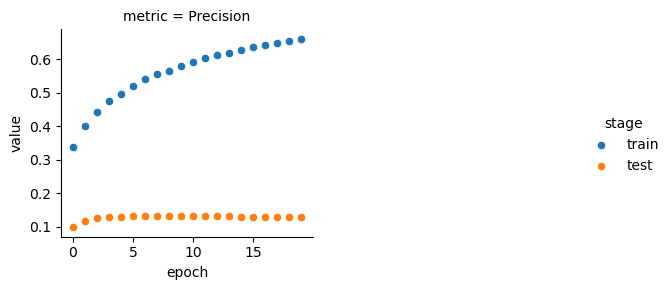

Train MAP@5: 0.6617
Test MAP@5: 0.1296


In [427]:
fm, m = track_model_metrics(model=model2, train_interactions=ua_interaction_csr_train, test_interactions=ua_interaction_csr_test, k= 5, no_epochs=20)
plt.show()
print("Train MAP@5"  + ": %.4f" % precision_at_k(m, ua_interaction_csr_train , k=5).mean())
print("Test MAP@5"  + ": %.4f" % precision_at_k(m, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean())

In [429]:
fm.loc[(fm.value.idxmax()) and (fm.stage == 'test')]

,epoch,value,stage,metric
1,0,0.099117,test,Precision
3,1,0.118965,test,Precision
5,2,0.125679,test,Precision
7,3,0.129036,test,Precision
9,4,0.130480,test,Precision
11,5,0.131416,test,Precision
13,6,0.132246,test,Precision
15,7,0.133396,test,Precision
17,8,0.133770,test,Precision
19,9,0.132807,test,Precision


In [430]:
score = auc_score( 
    model, ua_interaction_csr_test).mean()

In [431]:
score

0.87444913

In [432]:
precision_at_k(m, train_interactions = ua_interaction_csr_train, test_interactions=ua_interaction_csr_test, k=5).mean()

0.1295707

In [259]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    # Define the search space
    loss = trial.suggest_categorical('loss', ['warp'])
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.25)
    no_components = trial.suggest_int('no_components', 10, 150)
    no_epochs = trial.suggest_int('no_epochs', 10, 100)

    mm = LightFM(loss=loss, random_state=42, learning_rate=learning_rate, no_components=no_components)
    mm = mm.fit(interactions_train,
                item_features=item_features,
                  epochs=no_epochs,
                  num_threads=2, verbose=True)
    
    #score = precision_at_k(mm, interactions_train, item_features=item_features, k=5).mean()
    score = precision_at_k(mm, interactions_test, train_interactions=interactions_train, item_features=item_features, k=5).mean()
    #score = precision_at_k(mm, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean()
    #score = auc_score(mm, ua_interaction_csr_test).mean()
    return score

study = optuna.create_study(study_name="lightfm_optimization",
                            direction="maximize",
                            sampler=TPESampler())

study.optimize(objective, n_trials=15)
print(study.best_params)
print(study.best_value)

[I 2023-05-15 21:44:11,255] A new study created in memory with name: lightfm_optimization
Epoch: 100%|██████████| 72/72 [02:26<00:00,  2.03s/it]
[I 2023-05-15 21:46:42,933] Trial 0 finished with value: 0.09797338396310806 and parameters: {'loss': 'warp', 'learning_rate': 0.0902992628862337, 'no_components': 73, 'no_epochs': 72}. Best is trial 0 with value: 0.09797338396310806.
Epoch: 100%|██████████| 89/89 [03:24<00:00,  2.30s/it]
[I 2023-05-15 21:50:13,444] Trial 1 finished with value: 0.08069026470184326 and parameters: {'loss': 'warp', 'learning_rate': 0.12364768338687296, 'no_components': 114, 'no_epochs': 89}. Best is trial 0 with value: 0.09797338396310806.
Epoch: 100%|██████████| 31/31 [00:43<00:00,  1.39s/it]
[I 2023-05-15 21:51:00,640] Trial 2 finished with value: 0.09317102283239365 and parameters: {'loss': 'warp', 'learning_rate': 0.21719795344486847, 'no_components': 49, 'no_epochs': 31}. Best is trial 0 with value: 0.09797338396310806.
Epoch: 100%|██████████| 57/57 [01:58<

{'loss': 'warp', 'learning_rate': 0.1796792536493149, 'no_components': 10, 'no_epochs': 100}
0.11635342985391617


In [457]:
model_tuned = LightFM(loss='logistic', random_state=42, learning_rate=0.05794815454187041, no_components=94)
model_tuned = model_tuned.fit(ua_interaction_csr_train,
                epochs=37,
                num_threads=2, verbose=True)
print("Train MAP@5"  + ": %.4f" % precision_at_k(model_tuned, ua_interaction_csr_train , k=5).mean())
print("Test MAP@5"  + ": %.4f" % precision_at_k(model_tuned, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean())

Epoch: 100%|██████████| 37/37 [00:37<00:00,  1.00s/it]


Train MAP@5: 0.3308
Test MAP@5: 0.0547


Epoch: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


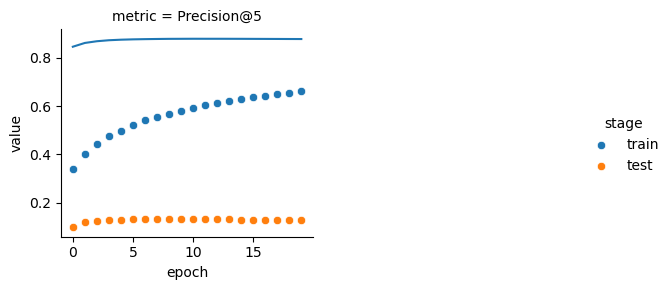

Train MAP@5: 0.6617
Test MAP@5: 0.1296


In [459]:
model_tuned = LightFM(loss='warp-kos', random_state=42, learning_rate=0.05, no_components=50)
fm, model_tuned = track_model_metrics(model=model_tuned, train_interactions=ua_interaction_csr_train, test_interactions=ua_interaction_csr_test, k= 5, no_epochs=20)
plt.show()
print("Train MAP@5"  + ": %.4f" % precision_at_k(model_tuned, ua_interaction_csr_train , k=5).mean())
print("Test MAP@5"  + ": %.4f" % precision_at_k(model_tuned, test_interactions=ua_interaction_csr_test, train_interactions=ua_interaction_csr_train , k=5).mean())

In [463]:
score = auc_score( 
    model_tuned, ua_interaction_csr_test)
score.mean()

0.87005013